### Edgar Moises Hernandez-Gonzalez
#### Asesores: Pilar Gomez-Gil, Erik Bojorges-Valdez
#### Instituto Nacional de Astrofísica Óptica y Electrónica (INAOE)
#### 26/11/20-03/12/20
#### Tesis: Clasificación de señales EEG basada en representaciones bidimensionales y redes neuronales convolucionales
#### Clasificacion de EEG con CNN-2D o CNN-2D + LSTM
##### Caracteristicas = Espectrogramas STFT o Escalogramas CWT

##### Mostrar las imagenes (STFT o CWT) y graficar las predicciones de la red neuronal (CNN-2D o CNN-2D + LSTM)

In [ ]:
# activar google drive
# no es necesario si se ejecuta local
from google.colab import drive

In [ ]:
# montar drive
# no es necesario si se ejecuta local
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ejecutar desde aqui si se ejecuta en su computadora local, importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
import pywt
import cv2
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                          TimeDistributed, LSTM)
from keras.optimizers import Adam
from keras import backend as K

In [ ]:
# para que este script funcione debe de decir 'channels_last'
# si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
# leer .csv con los datos de train y test
# se debe especificar la ruta
# header = None significa que los .csv no tienen encabezado
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/MI-EEG-B9T.csv",
                      header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/MI-EEG-B9E.csv",
                     header=None)
# de las etiquetas obtener solo el valor
# en lugar de obtener un dataframe pandas se obtiene un array numpy
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/etiquetas_train_9.csv",
                      header=None).values
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/etiquetas_test_9.csv",
                     header=None).values

In [ ]:
# escribir el nombre de las clases
#class_names = ['left hand', 'right hand', 'both feet', 'tongue']
class_names = ['izquierda', 'derecha']

In [ ]:
# imprimir la forma de las matrices de datos
# x_train y x_test son matrices donde las filas son el numero de ejemplos
# y las columnas son el numero de segundos por la frecuencia de muestreo
# por el numero de canales
# y_train y y_test son las etiquetas
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 3000)
(320, 3000)
(400, 1)
(320, 1)


In [ ]:
# calcular el numero de muestras
# en caso de no tener el y_test se puede utilizar el x_test
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 400
n_samples_test : 320


In [ ]:
# calcular el numero de clases
# esto se podria calcular asi n_clases = len(np.unique(y))
# la y puede ser train o test
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [ ]:
# calcular espectrogramas con STFT
# concatenacion vertical de los espectrogramas de los n canales
# unir_espectrogramas_vertical(matriz de x_train o x_test,
# frecuencia de muestreo, alto, ancho, n_canales, tamano del segmento de senal,
# puntos superpuestos para calcular la STFT)
def unir_espectrogramas_vertical(data, fs, alto, ancho, n_canales, pts_sig,
                                 pts_superpuestos):
  #fs = fs #frecuencia de muestreo
  # crear matriz 3D para almacenar todas las imagenes de los STFT
  datos = np.zeros((data.shape[0],alto, ancho))
  
  # crear matriz 2D donde se guardara cada imagen del STFT
  temporal = np.zeros((alto, ancho))

  for i in range(data.shape[0]): # n muestras
    for j in range(n_canales): # n canales
      # puntos_sig = duracion en segundos de la señal x frecuencia de muestreo
      # para una señal de 2 seg con fs de 250 Hz, puntos_sig = 500
      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]
      
      # espectrograma con STFT
        # senal,
        # fs=frecuencia de muestreo,
        # window='tipo de ventana',
        # nperseg=tamano de ventana,
        # noverlap=puntos superpuestos,
        # nfft=tamano de la FFT con relleno de ceros, Si=None la longitud de FFT es nperseg
        # scaling=‘density’: power spectral density, ‘spectrum’: power spectrum
      f, t, Sxx = spectrogram(sig, fs=fs, window='hann', nperseg=fs,
                              noverlap=pts_superpuestos, nfft=fs*2,
                              scaling='spectrum')
      
      # concatenacion vertical de canales
      # espectrograma genera 45 filas (frecuencias de 8 a 30Hz con pasos de
      # 0.5Hz) y 31 columnas (tiempo)
      # las frecuncias de 8 a 30 Hz estan entre los indices de 16 a 60
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]

    datos[i] = temporal
    if i % 100 == 0: # esto es para ver como avanza
      print(i)
  return datos

In [ ]:
# calcular escalogramas con CWT
# concatenacion vertical de los escalogramas de los n canales
# unir_escalogramas_vertical(matriz de x_train o x_test, frecuencia de muestreo,
# alto, ancho, n_canales, tamano del segmento de senal):
def unir_escalogramas_vertical(data, fs, alto, ancho, n_canales, pts_sig):
  # ancho y alto, para el resize usando Open CV
  dim = (int(np.floor(ancho/2)), int(np.floor(alto/2))) # ancho, alto
  
  # calcular escalas para Wavelet compleja de Morlet 3-3
  # con frecuencias de 8 a 30 Hz con pasos de 0.5 Hz
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  
  # crear matriz 3D para almacenar todas las imagenes
  datos = np.zeros((data.shape[0], int(np.floor(alto/2)),
                    int(np.floor(ancho/2))))
  
  # crear matriz 2D donde se guardara cada imagen
  temporal = np.zeros((alto, ancho))

  for i in range(data.shape[0]): # n muestras
    for j in range(n_canales): # n canales
      # puntos_sig = duracion en segundos de la señal x frecuencia de muestreo
      # para una señal de 2 seg con fs de 250 Hz, puntos_sig = 500
      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]
      
      # escalograma con CWT
        # senal
        # escalas
        # nombre de la wavelet, en este caso compleja de Morlet 3-3
        # periodo de muestreo = 1 / frecuencia de muestreo
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3',
                             sampling_period = (1 / fs))
      
      # concatenacion vertical de canales
      # espectrograma genera 45 filas (frecuencias de 8 a 30Hz con pasos de
      # 0.5Hz) y 31 columnas (tiempo)
      # dado que cmor3-3 genera numeros complejos, calcular el modulo
      temporal[j*45:(j+1)*45, :] = abs(coef)

    # resize usando una interpolacion interarea con OpenCV
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: # esto solo es para ver como avanza
      print(i)
  return datos

In [ ]:
# seleccionar STFT o CWT
inicio = time.time()

# STFT, llamar a unir_espectrogramas_vertical(data, fs, alto, ancho,
# n_canales, pts_sig, pts_superpuestos))
# descomentar las siguientes dos lineas para STFT
x_train = unir_espectrogramas_vertical(x_train, 250, 135, 31, 3, 1000, 225)
x_test = unir_espectrogramas_vertical(x_test, 250, 135, 31, 3, 1000, 225)

# CWT, llamar a unir_escalogramas_vertical(data, fs, alto, ancho,
# n_canales, pts_sig)
# descomentar las siguientes dos lineas para CWT
#x_train = unir_escalogramas_vertical(x_train, 250, 135, 1000, 3, 1000)
#x_test = unir_escalogramas_vertical(x_test, 250, 135, 1000, 3, 1000)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
0
100
200
300
Tiempo: 1.62508225440979


In [ ]:
# forma de los espectrogramas (STFT) o escalogramas (CWT)
# la forma debe ser tridimensional
# la primera dimension es igual al numero de ejemplos
# la segunda dimension es lo alto de las imagenes calculadas con STFT o CWT
# la tercera dimension es lo ancho de las imagenes calculadas con STFT o CWT
print(x_train.shape)
print(x_test.shape)

(400, 135, 31)
(320, 135, 31)


In [ ]:
# imprimir el maximo, minimo y la media del x_train y del x_test
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

10.7888912416627
5.9735068449728965
3.407406192918792e-08
4.7948568293571226e-08
0.07563276860670194
0.054174781359652736


In [ ]:
# redondear al techo el max de x_train
x = np.ceil(np.max(x_train))

In [ ]:
# convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# escalar los valores en un rango de 0 a 1 (normalizar)
# dividir entre el max redondeado al techo
x_train /= x
x_test /= x

In [ ]:
# imprimir el maximo, minimo y la media del x_train y del x_test
# despues de normalizar los datos
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.98080826
0.54304606
3.0976421e-09
4.3589607e-09
0.0068757054
0.004924981


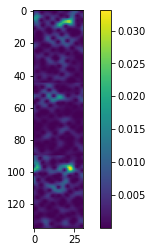

In [ ]:
# mostrar el ejemplo 2 de x_train
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

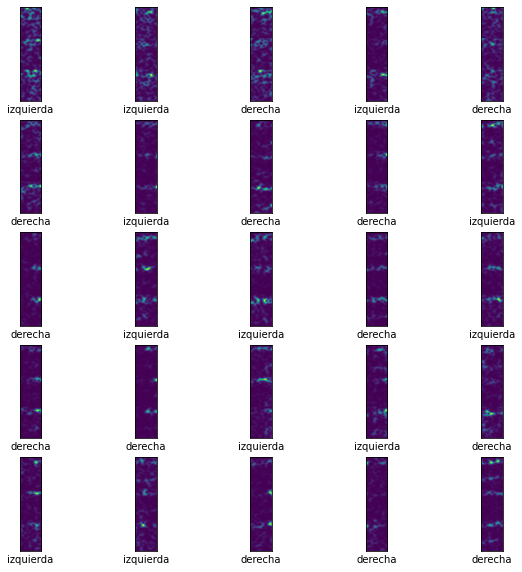

In [ ]:
# mostrar los primeros 25 ejemplos del x_train
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i,0]])
plt.show()

In [ ]:
# seleccionar reshape a 4D (para CNN-2D) o 5D (para CNN-2D + LSTM)
# para CNN-2D usar a 4D, para CNN-2D + LSTM usar a 5D

# convertir de 3D a 4D (CNN-2D)
# descomentar las siguientes dos lineas para usar CNN-2D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# convertir de 3D a 5D (CNN-2D + LSTM)
# descomentar las siguientes dos lineas para usar CNN-2D + LSTM
#x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
#x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

# imprimir la forma
print(x_train.shape)
print(x_test.shape)

(400, 135, 31, 1)
(320, 135, 31, 1)


In [ ]:
# crear red neuronal CNN-2D
# se debe especificar el numero de filtros, el tamano de los filtros
# y el numero de neuronas en la capa oculta del MLP (Dense)
# modelo secuencial de dos capas convolucionales 2D con activacion relu y
# relleno de ceros y max pooling de 2x2
# aplanar los mapas de caracteristicas para convertirlas de una matriz 3D a
# un vector 1D
# MLP de una capa oculta con relu
# regularizacion con dropout de 0.5
# la ultima capa utiliza una funcion softmax para obtener una distribucion
# de probabilidad
# optimizador Adam con tasa de aprendizaje de 1x10-4
# la funcion de perdida es la entropia cruzada categorica
# (se utiliza sparse para no convertir las etiquetas a one hot)
# la metrica a evaluar es el accuracy
def CNN_2D(n_filtros, tamano_filtros, n_neuronas):
  model = Sequential()
  model.add(Conv2D(n_filtros, tamano_filtros, activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(n_filtros, tamano_filtros, activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(n_neuronas, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
# crear red neuronal CNN-2D + LSTM
# se debe especificar el numero de filtros, el tamano de los filtros,
# el numero de neuronas en la capa oculta del MLP (Dense) y el numero de
# unidades LSTM 
# modelo secuencial de dos capas convolucionales 2D con activacion relu y
# relleno de ceros y max pooling de 2x2
# aplanar los mapas de caracteristicas para convertirlas de una matriz 3D a
# un vector 1D
# red recurrente LSTM con activacion tangente hiperbolica y dropout de 0.5
# (esta va entre las capas convolucionales y el MLP)
# MLP de una capa oculta con relu
# regularizacion con dropout de 0.5
# la ultima capa utiliza una funcion softmax para obtener una distribucion
# de probabilidad
# optimizador Adam con tasa de aprendizaje de 1x10-4
# la funcion de perdida es la entropia cruzada categorica
# (se utiliza sparse para no convertir las etiquetas a one hot)
# la metrica a evaluar es el accuracy
# para poder conectar CNN-2D con LSTM se debe utilizar la capa TimeDistributed
def CNN_2D_LSTM_TD(n_filtros, tamano_filtros, n_neuronas, unidades_LSTM):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(n_filtros, tamano_filtros, activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(n_filtros, tamano_filtros, activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(unidades_LSTM, activation='tanh', dropout=0.5))
  model.add(Dense(n_neuronas, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.43585920333862305
accuracy:  0.784375011920929
kappa:  0.56875
confusion matrix:
 [[139  21]
 [ 48 112]]


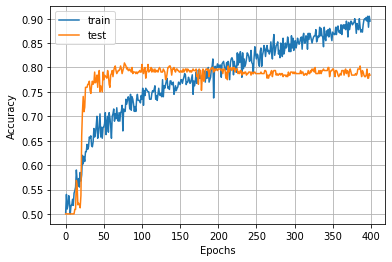

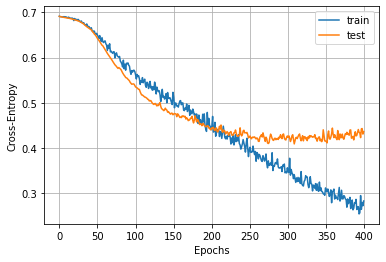


Resultados:
loss: [0.43585920333862305]
accuracy: [0.784375011920929]
kappa: [0.56875]
Tiempo: 24.967310905456543


In [ ]:
inicio = time.time()
array_loss = [] # arreglo para las perdidas
array_acc = [] # arreglo para los accuracy
array_kappa = [] # arreglo para las kappas
# numero de ejecuciones, 1 porque solo queremos ver los resultados de una ejecución
for i in range(1):
  print("Iteration:", i+1)
    
  # seleccionar la red neuronal
  model = CNN_2D(4, (3,3), 32)
  #model = CNN_2D_LSTM_TD(4, (3,3), 32, 4)

  # entrenar red neuronal
    # para STFT = 400 epochs, para CWT = 100 epochs
    # batch_size: su tamano es opcional (depende del dataset)
    # x_train: matriz
    # y_train: etiquetas
    # epochs: numero epocas
    # batch_size: tamano del lote (entre mas pequeño tarda mas el entrenamiento)
    # validation_data: estos datos son para evaluar la red en cada epoca, es
      # importante mencionar que estos datos no se utilizan para entrenar la
      # red solo son para evaluar en cada epoca
    # verbose: 0 para no imprimir el proceso de entrenamiento, otras opciones
      # pueden ser 1 o 2
  # callbacks: guardar el modelo en cada epoca y reemplazar solo si es mejor
    #al anterior
  history = model.fit(x_train, y_train, epochs=400, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)
                      #,callbacks=[mc]) # descomentar para guardar el modelo
    
  # evaluar red neuronal con x_test y y_test
  # (datos que nunca se le presentaron a la red en el entrenamiento)
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss) # agregar test_loss al arreglo array_loss
  print("loss: ", test_loss)
  array_acc.append(test_acc) # agregar test_acc al arreglo array_acc
  print("accuracy: ", test_acc)
    
  # predecir x_test (distribucion de probabilidad)
  probabilidades = model.predict(x_test)
  
  # obtener las etiquetas predichas calculando el indice del maximo
  # de la distribucion de probalidad
  y_pred = np.argmax(probabilidades, 1) # 1 = fila
    
  # calcular kappa de cohen
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa) # agregar test_acc al arreglo array_acc
  print("kappa: ", kappa)
  
  #calcular matriz de confusion
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  # graficar el comportamiento del accuracy y de la perdida en cada epoca
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [ ]:
# resumen del modelo (red neuronal)
# se muestra la forma de la salida de cada capa y
# el numero de parametros a apreder en cada capa
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 135, 31, 4)        40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 67, 15, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 15, 4)         148       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 7, 4)          0         
_________________________________________________________________
flatten (Flatten)            (None, 924)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                29600     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [ ]:
# imprimir media, desviacion estandar y maximo de accuracy y kappa
# y el tiempo de las n ejecuciones independientes
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.7844
std: (+/- 0.0000)
Mean Kappa: 0.5687
std: (+/- 0.0000)
Max Accuracy: 0.7844
Max Kappa: 0.5687
Tiempo: 24


In [ ]:
# imprime la imagen
# plot_image(i_ejemplo, probabilidades_prediccion, y_test, x_test, alto, ancho)
def plot_image(i, predictions_array, true_label, img, alto, ancho):
    predictions_array, true_label, img = predictions_array[i], true_label[i,0], img[i]
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(img.reshape(alto, ancho))

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [ ]:
# densidad de probabilidad de las predicciones
# plot_value_array(i_ejemplo, probabilidades_prediccion, y_test)
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i,0]
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
# imprimir la etiqueta verdadera y la predicha
# recuerde que 4D para CNN-2D y 5D para CNN-2D + LSTM
num_test = 28 # num de ejemplo a predecir
print("Etiqueta verdadera", y_test[num_test])

# CNN-2D
# reshape(batch (siempre es 1, porque vamos a predecir un ejemplo),
# alto, ancho, (siempre es 1))
prediccion = model.predict(x_test[num_test].reshape(1,135,31,1))

# CNN-2D + LSTM
# reshape(batch (siempre es 1, porque vamos a predecir un ejemplo),
# (siempre es 1), alto, ancho, (siempre es 1))
#prediccion = model.predict(x_test[num_test].reshape(1,1,67,500,1))

print("Etiqueta predicha", prediccion.argmax())

Etiqueta verdadera [1]
Etiqueta predicha 1


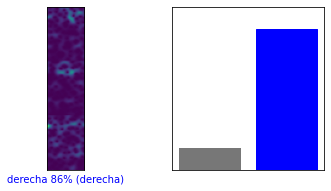

In [ ]:
# imprimir un ejemplo de x_test y su prediccion
i = num_test
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, probabilidades, y_test, x_test, 135, 31)
plt.subplot(1,2,2)
plot_value_array(i, probabilidades,  y_test)
plt.show()

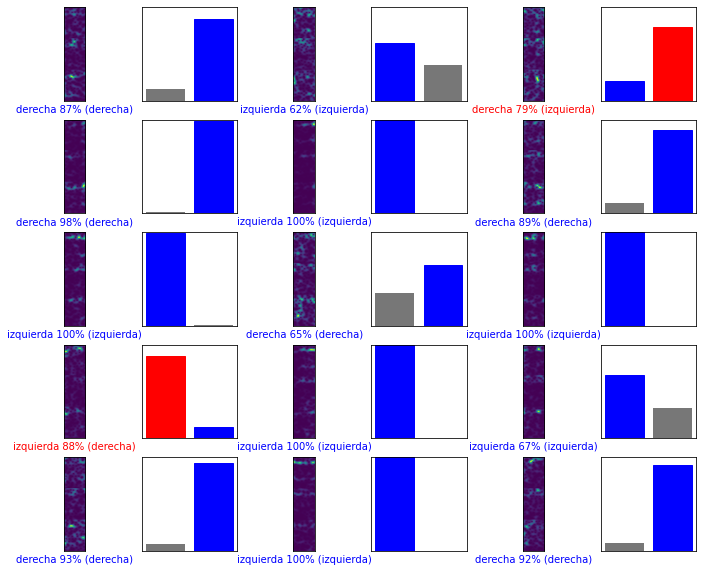

In [ ]:
#Graficar imagenes, etiqueta predicha y etiqueta verdadera
#Correcta en azul, incorrecta en rojo
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, probabilidades, y_test, x_test, 135, 31)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, probabilidades, y_test)
plt.show()